<a href="https://colab.research.google.com/github/substantivum/dlbts/blob/master/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the dataset

### Using [BraTS2020 Dataset (Training + Validation)](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/code).

The Brain Tumor Segmentation (BraTS) 2020 dataset consists of multimodal Magnetic Resonance Imaging (MRI) scans designed for brain tumor segmentation.

This dataset includes MRI scans from glioma patients, where each patient has four different MRI modalities (i.e., four channels of information representing different volumes of the same brain region):

- T1 (Native)
- T1ce (Post-contrast T1-weighted, contrast-enhanced)
- T2 (T2-weighted)
- T2-FLAIR (Fluid-Attenuated Inversion Recovery)

In [ ]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation

In [ ]:
! unzip brats20-dataset-training-validation.zip

### Importing all the libraries

In [ ]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import shutil  # For copying files
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Rescaling, Normalization, RandomFlip, RandomRotation, RandomZoom

In this dataset there are some of the files that are not consistently named, in this case we rename them.

In [ ]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File has been re-named successfully!


In [ ]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


Rescaling images to ensure that the data is normalized/standardized for model input without altering its spatial structure.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [ ]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

In [ ]:
from matplotlib.colors import ListedColormap

tumor_cmap = ListedColormap(['#bbd0ff', '#fca311', '#ff70a6', '#0077b6'])

Slice Number: 102


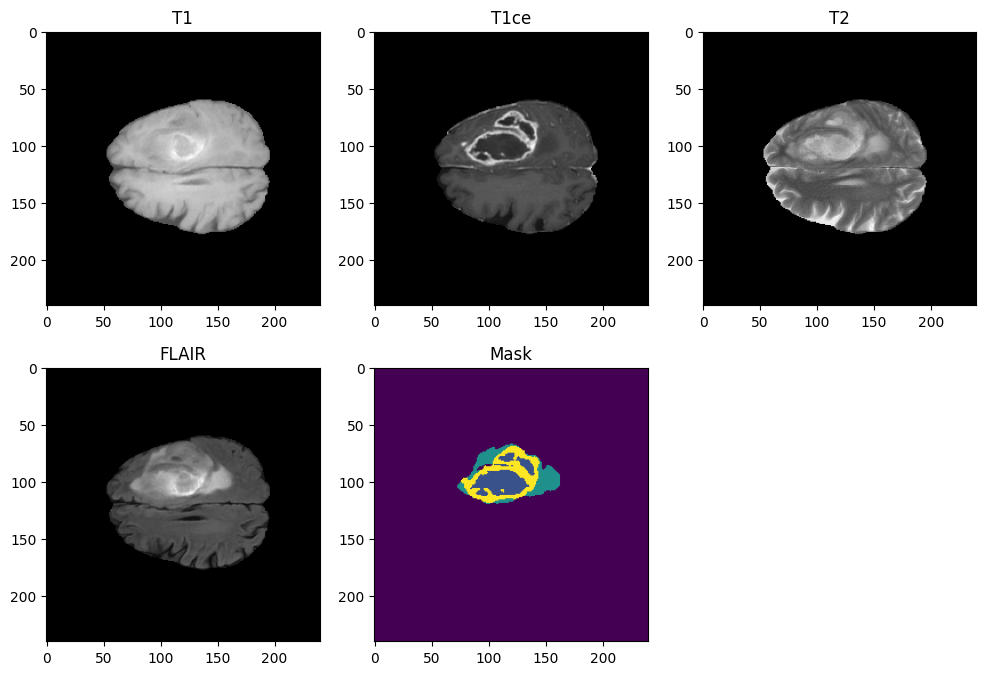

In [ ]:
slice = 102

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 102


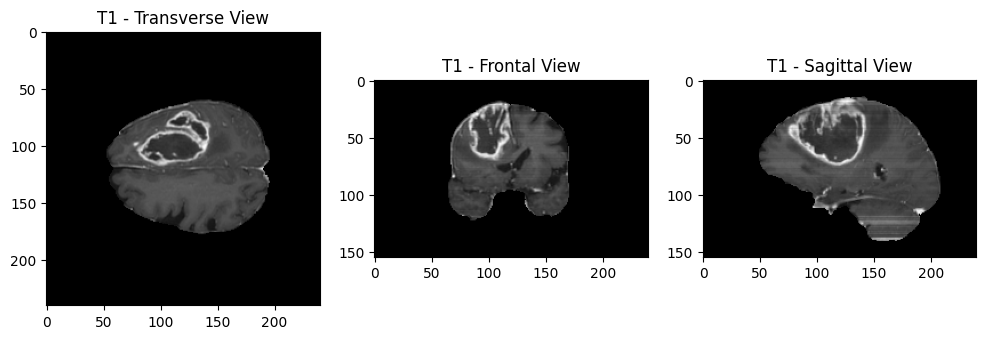

In [ ]:
slice = 102

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# 90° rotation with an automatic resizing
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

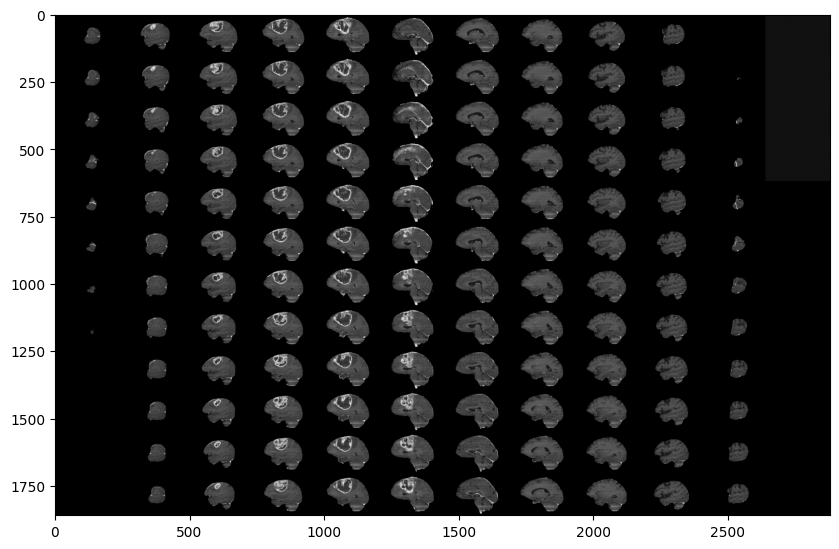

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

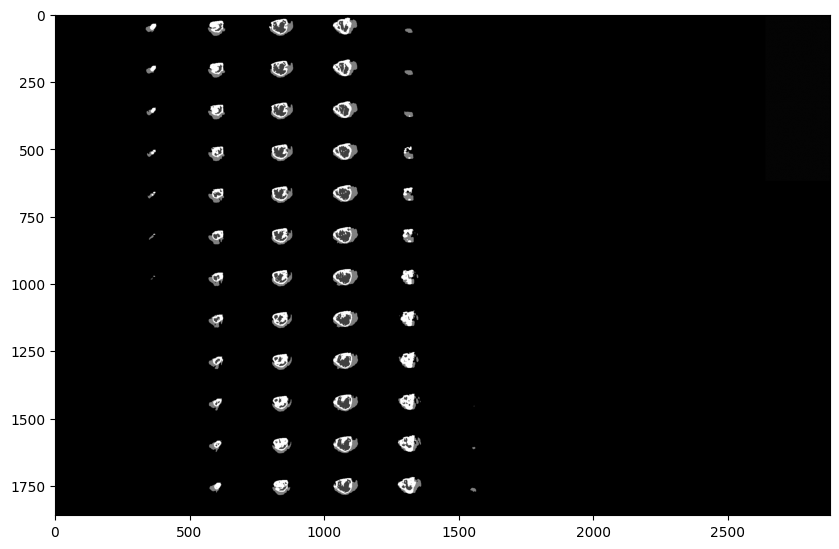

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

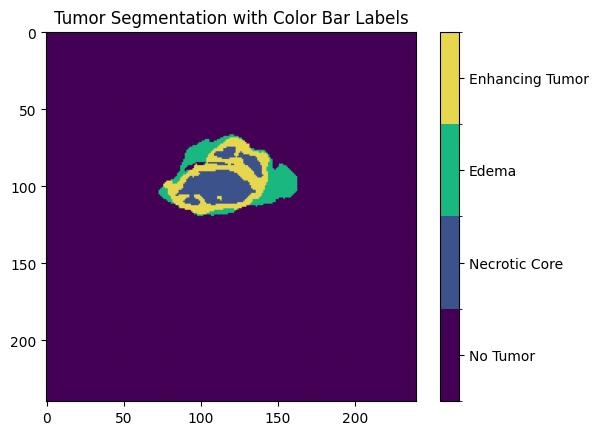

In [ ]:
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

fig, ax = plt.subplots()
im = ax.imshow(test_image_seg[:,:,slice], cmap=cmap, norm=norm)

cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])

cbar.set_ticklabels(['No Tumor', 'Necrotic Core', 'Edema', 'Enhancing Tumor'])

plt.title('Tumor Segmentation with Color Bar Labels')
plt.show()

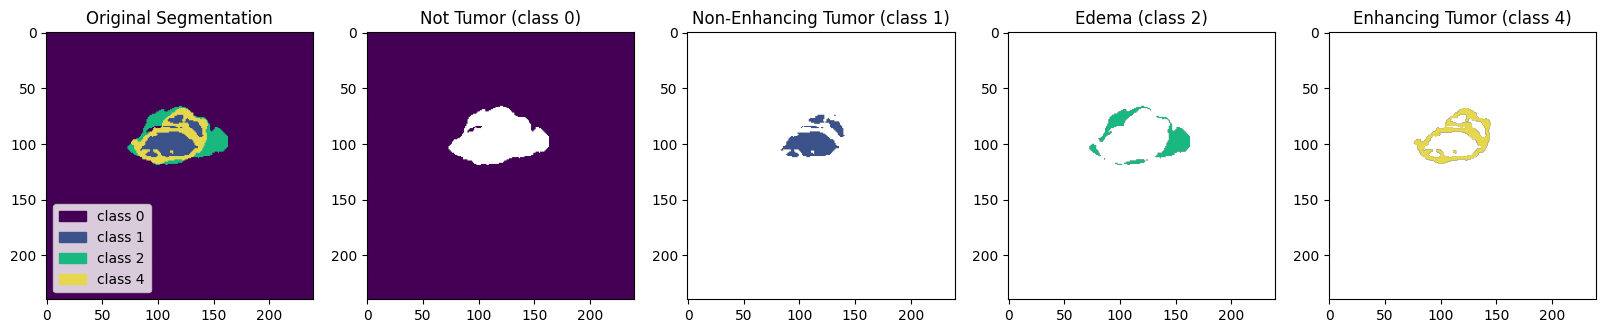

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

## Splitting the Dataset

In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


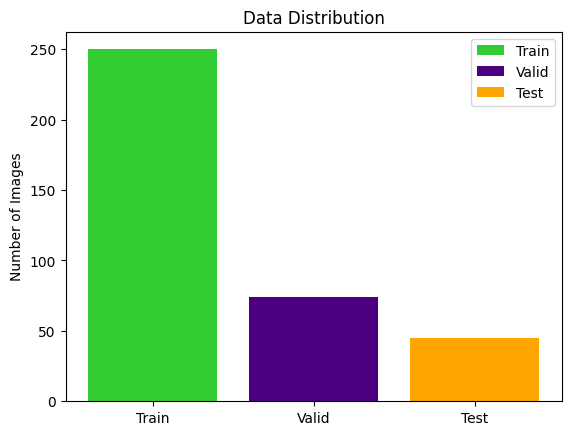

In [ ]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'limegreen','indigo', 'orange'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # 4 -> 3
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'

        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

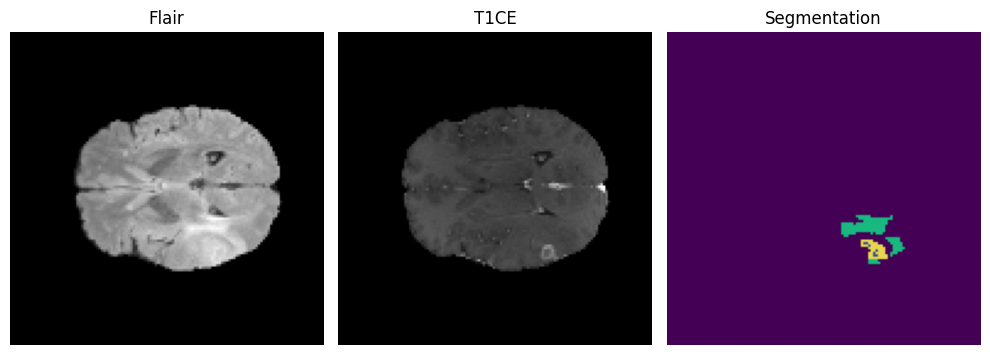

In [ ]:
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap=cmap)
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

X_batch, Y_batch = training_generator[11]

flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)

slice_index = 54
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0  # Initialize total_loss to 0 before the loop
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss = total_loss + loss

    total_loss = total_loss / class_num
    return total_loss

In [ ]:
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [ ]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def dice_loss(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    return 1 - (2. * intersection + smooth) / (K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) + smooth)

def combined_loss(y_true, y_pred):
    return keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
print(IMG_SIZE)

128


In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))


model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

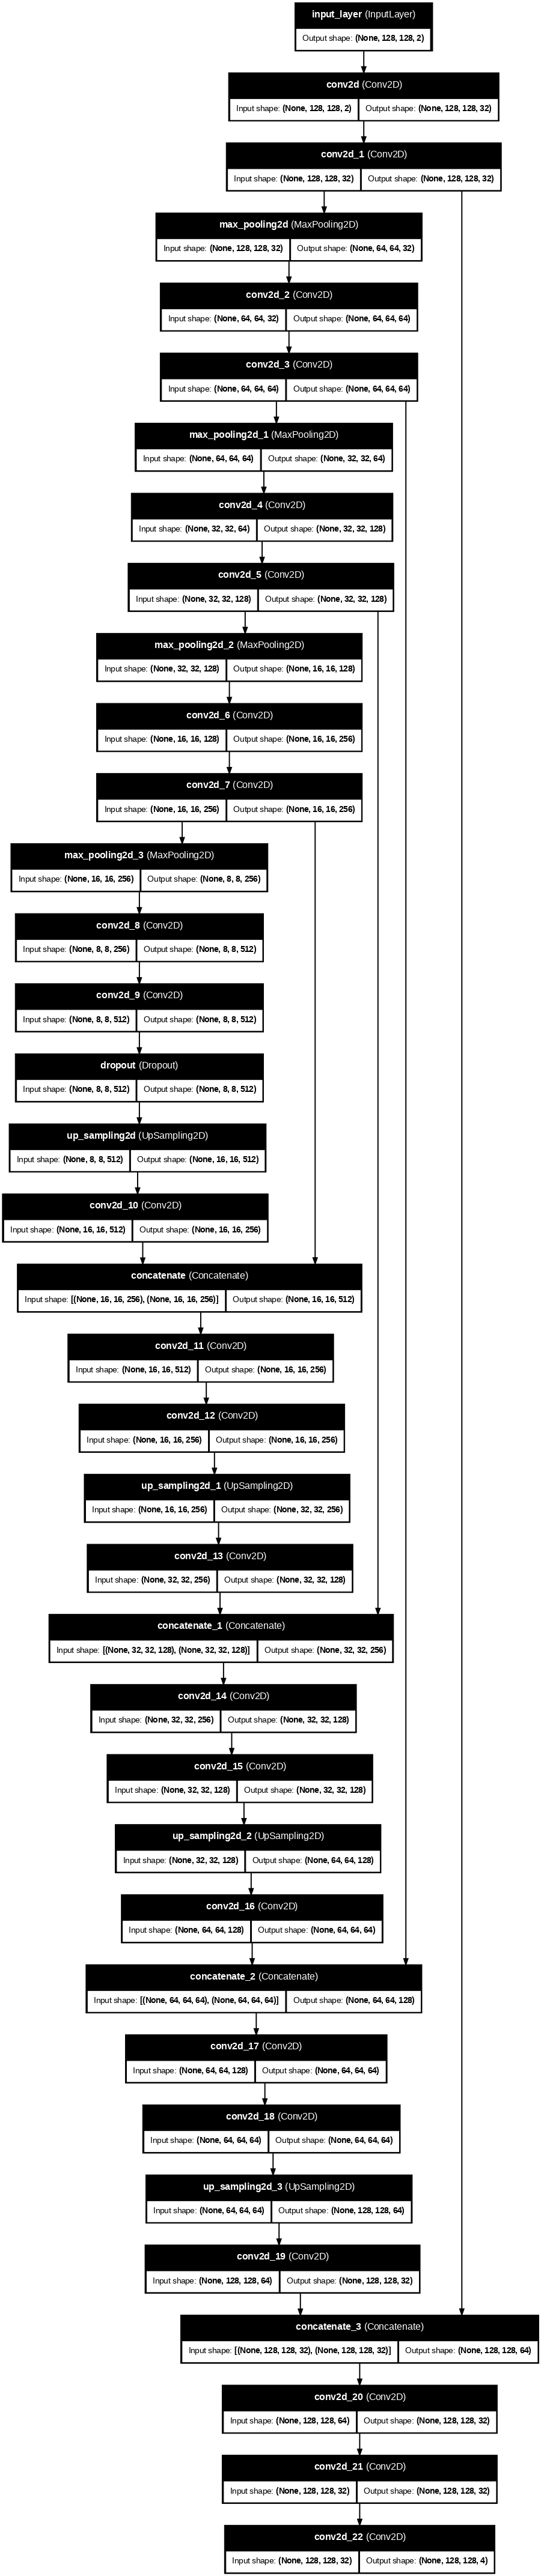

In [ ]:
plot_model(model,
           to_file="unet_model.png",
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

In [ ]:
checkpoint_dir = "/content/"

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + 'model_weights.{epoch:02d}-{val_loss:.6f}.weights.h5',
                                    verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger(checkpoint_dir + 'training_10.log', separator=',', append=True)
]

In [ ]:
# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Check if GPU is being used
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU: True


In [ ]:
!nvidia-smi

Wed Apr  9 08:49:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   46C    P0             28W /   72W |     577MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!cat /proc/cpuinfo

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=20,
                    steps_per_epoch=len(training_generator),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

In [ ]:
model.save("/content/my_model_10.keras")

model.save_weights("/content/weighs_model_10.weights.h5")

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/thesis/my_model_7.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
model.load_weights('/content/model_weights.15-0.018476.weights.h5')

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

In [ ]:
print(hist.columns)

Index(['epoch', 'accuracy', 'dice_coef', 'dice_coef_edema',
       'dice_coef_enhancing', 'dice_coef_necrotic', 'learning_rate', 'loss',
       'mean_io_u', 'precision', 'sensitivity', 'specificity', 'val_accuracy',
       'val_dice_coef', 'val_dice_coef_edema', 'val_dice_coef_enhancing',
       'val_dice_coef_necrotic', 'val_loss', 'val_mean_io_u', 'val_precision',
       'val_sensitivity', 'val_specificity'],
      dtype='object')


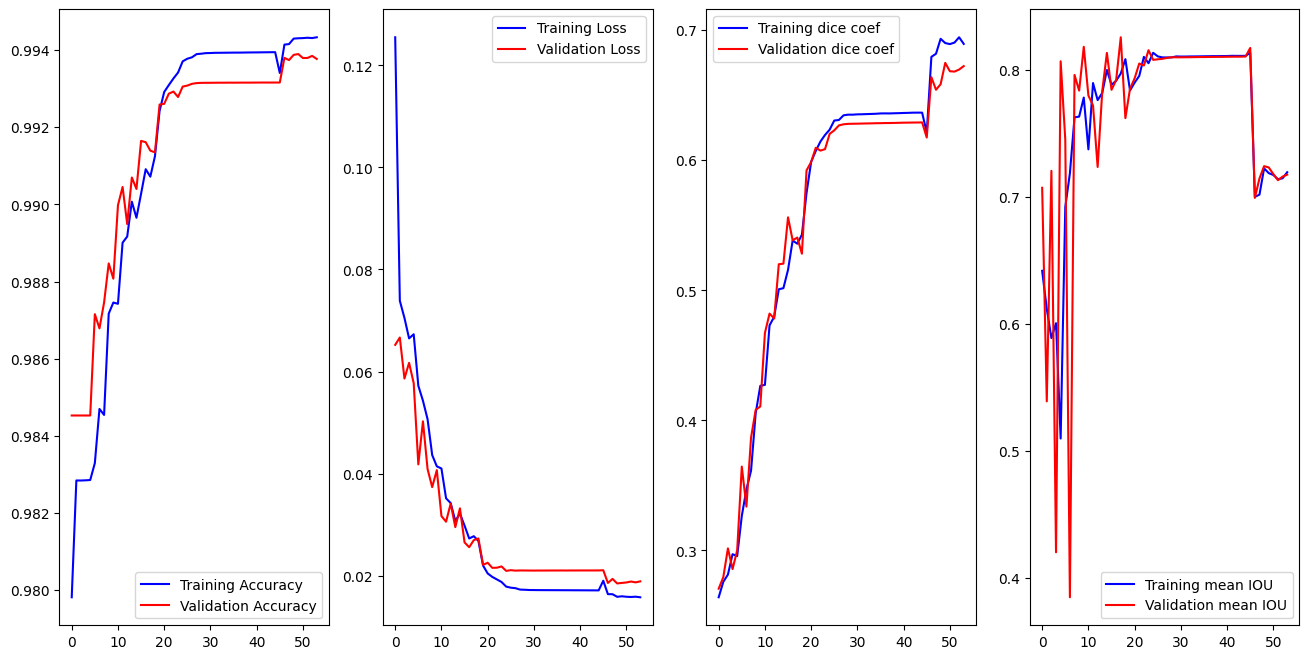

In [ ]:
history = pd.read_csv('/content/training_7.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('/content/model_weights.15-0.018476.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def showPredictsById(case, start_slice = 60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step


<Figure size 1800x5000 with 0 Axes>

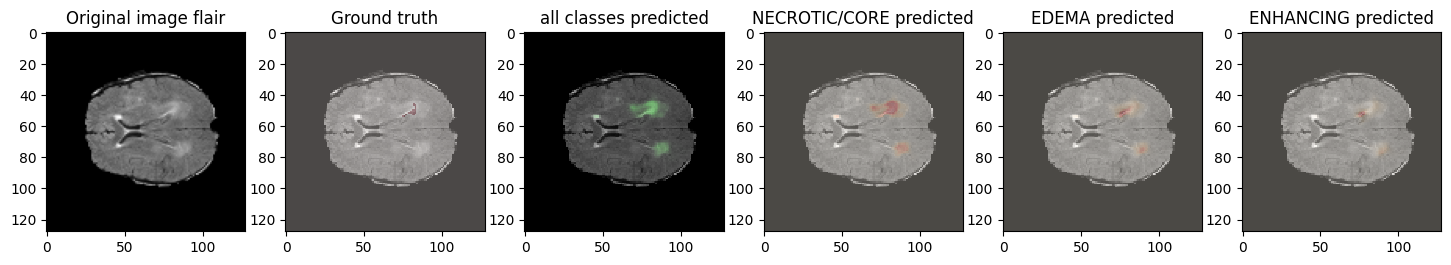

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

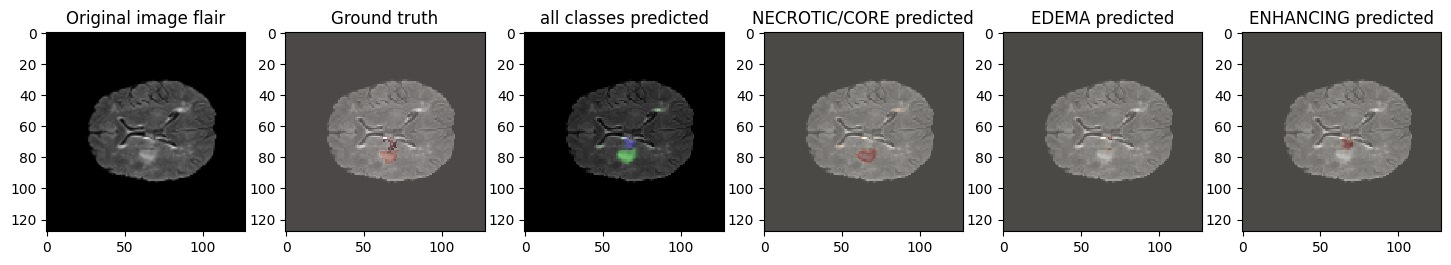

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

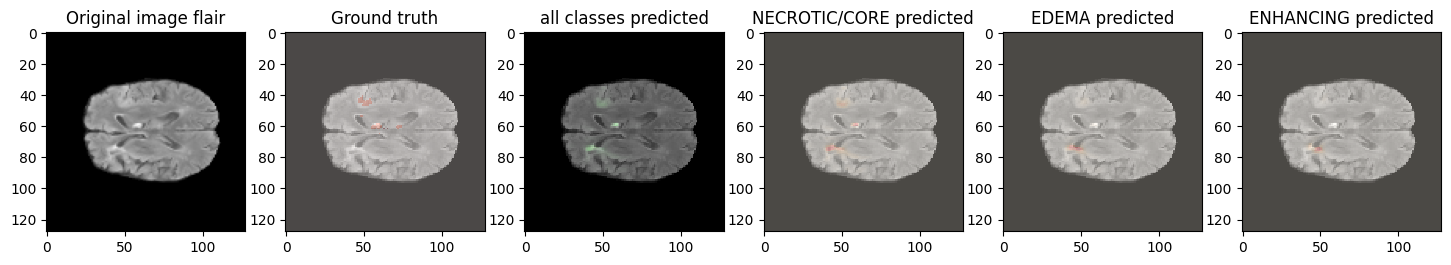

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

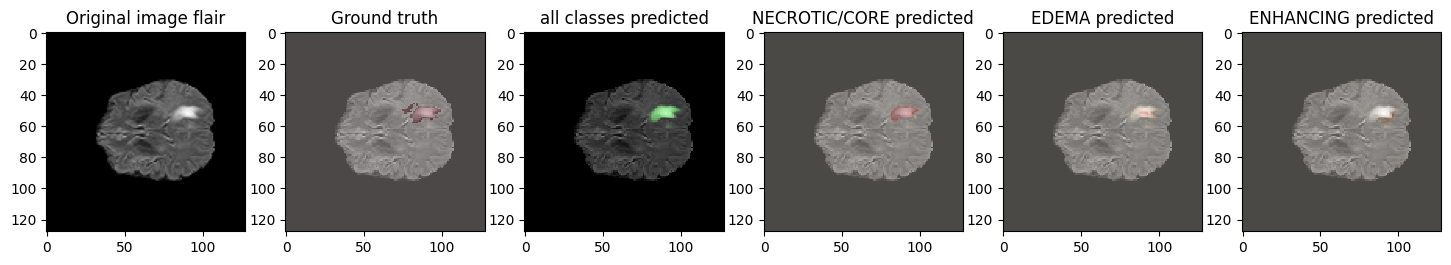

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

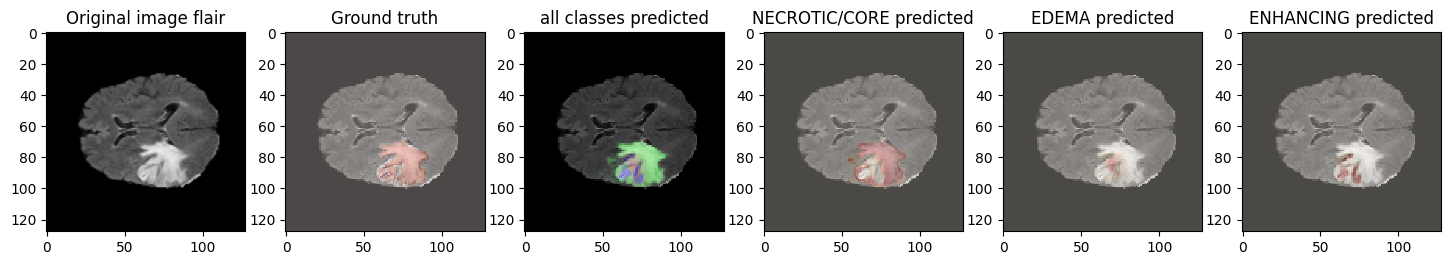

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

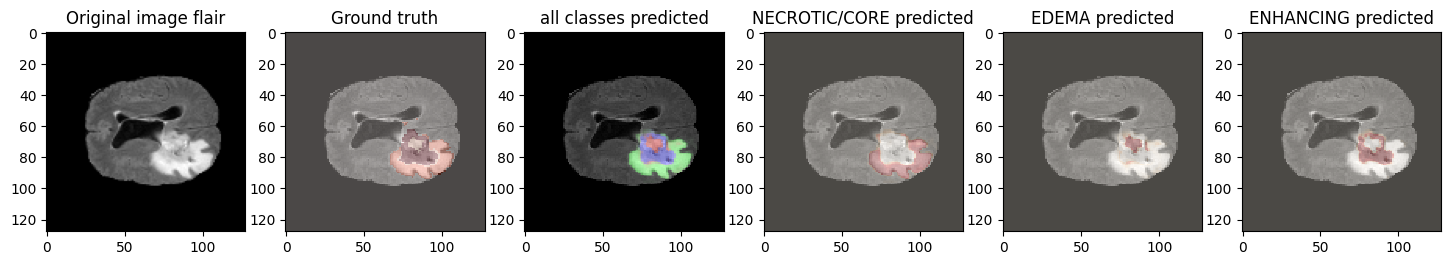

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 1800x5000 with 0 Axes>

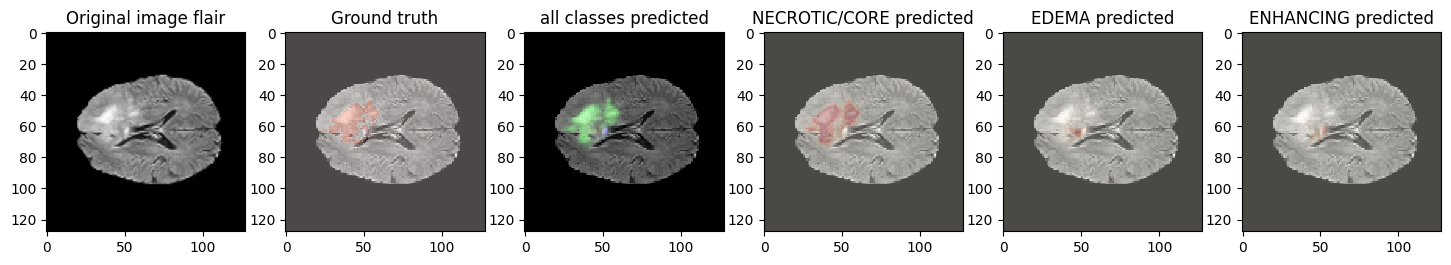

In [ ]:
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    random_sample = random.choice(samples_list)

    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    predicted_seg = predict_segmentation(random_sample_path)

    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    plt.subplots_adjust(wspace=0.8)

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Patient number:  BraTS20_Training_343


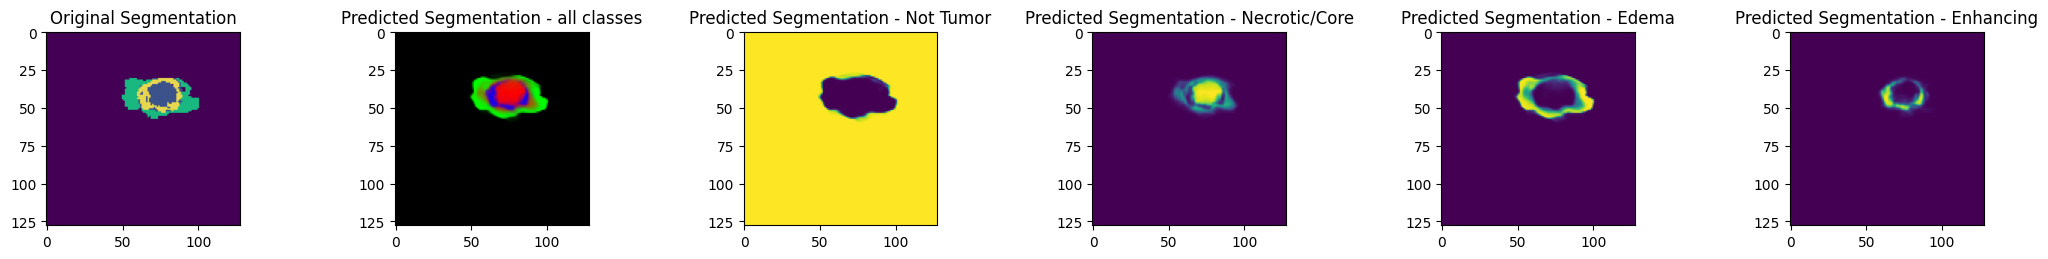

In [ ]:
show_predicted_segmentations(test_ids, 41, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 738ms/step
Patient number:  BraTS20_Training_269


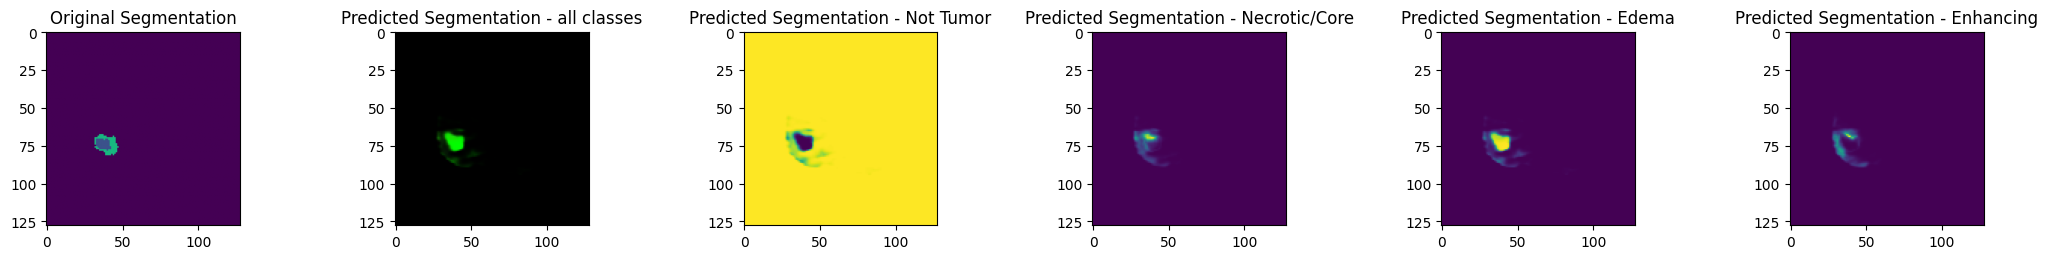

In [ ]:
show_predicted_segmentations(test_ids, 53, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Patient number:  BraTS20_Training_328


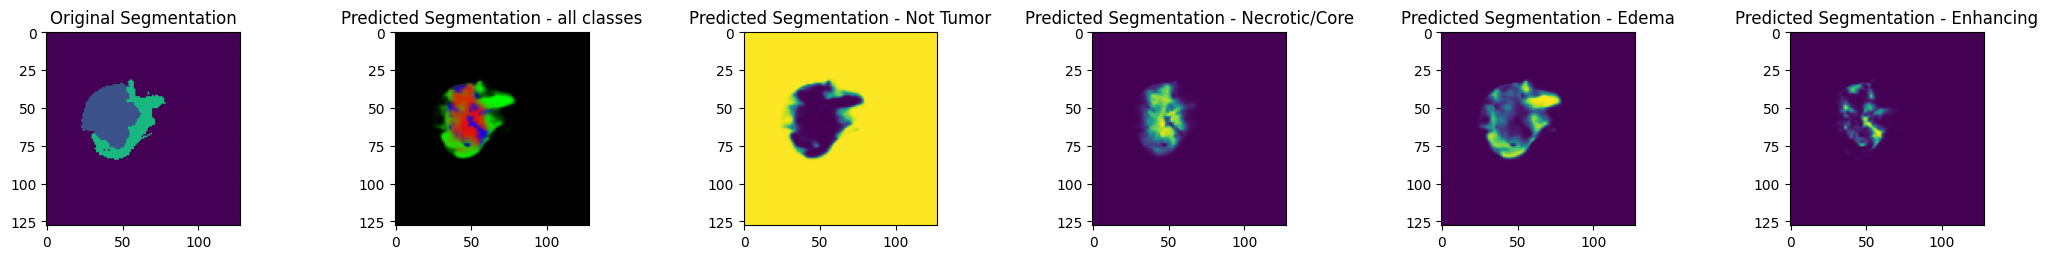

In [ ]:
show_predicted_segmentations(test_ids, 60, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Patient number:  BraTS20_Training_148


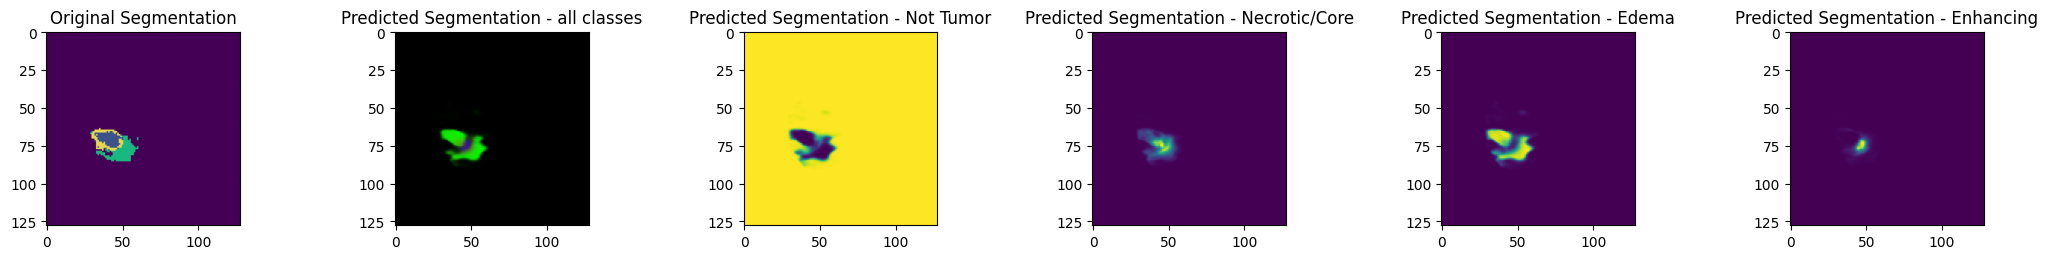

In [ ]:
show_predicted_segmentations(test_ids, 72, cmap, norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Figure size 640x480 with 0 Axes>

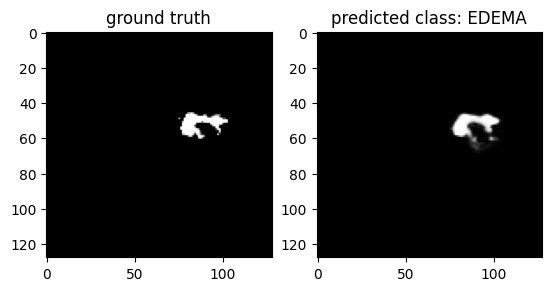

In [ ]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=67 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.9939 - dice_coef: 0.6384 - dice_coef_edema: 0.7547 - dice_coef_enhancing: 0.7011 - dice_coef_necrotic: 0.6597 - loss: 0.0175 - mean_io_u_16: 0.6952 - precision: 0.9946 - sensitivity: 0.9924 - specificity: 0.9981

Model evaluation on the test set:
Loss : 0.0172
Accuracy : 0.994
MeanIOU : 0.7067
Dice coefficient : 0.66
Precision : 0.9945
Sensitivity : 0.9926
Specificity : 0.9981
Dice coef Necrotic : 0.6851
Dice coef Edema : 0.7695
Dice coef Enhancing : 0.7614


## Training FCN architectures (FCN-32, FCN-16, or FCN-8) for comparing the results of the 2D U-Net.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Add, Input
from tensorflow.keras.models import Model

def FCN32(input_shape=(128, 128, 2), n_classes=4):
    # Input layer
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transposed
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc6')(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc7')(x)

    # FCN-32s layer
    x = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_fr')(x)

    # Upsampling x32
    x = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(32, 32), padding='same',
                        use_bias=False, name='upscore')(x)

    # Output
    outputs = tf.keras.layers.Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='fcn32')

    return model

In [ ]:
def FCN16(input_shape=(128, 128, 2), n_classes=4):
    # Input layer with explicit name
    inputs = Input(shape=input_shape, name='input_1')

    # Encoder (VGG-style) with consistent naming
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    pool1 = MaxPooling2D((2, 2), name='block1_pool')(x)  # 64x64

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(pool1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    pool2 = MaxPooling2D((2, 2), name='block2_pool')(x)  # 32x32

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(pool2)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    pool3 = MaxPooling2D((2, 2), name='block3_pool')(x)  # 16x16

    # Block 4 (skip connection source)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), name='block4_pool')(x)  # 8x8

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), name='block5_pool')(x)  # 4x4

    # FCN Head with dropout and explicit naming
    fc6 = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc6')(pool5)
    fc6 = Dropout(0.5, name='dropout_1')(fc6)
    fc7 = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc7')(fc6)
    fc7 = Dropout(0.5, name='dropout_2')(fc7)

    # Score layers with explicit naming and linear activation
    score_pool5 = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_pool5')(fc7)
    score_pool4 = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_pool4')(pool4)

    # Upsampling with consistent settings
    upscore2 = Conv2DTranspose(n_classes, (4, 4), strides=(2, 2),
                              padding='same', use_bias=False, name='upscore2')(score_pool5)

    # Skip connection fusion
    fuse_pool4 = Add(name='fuse_pool4')([upscore2, score_pool4])

    # Final upsampling
    upscore16 = Conv2DTranspose(n_classes, (32, 32), strides=(16, 16),
                               padding='same', use_bias=False, name='upscore16')(fuse_pool4)

    # Output with explicit name
    outputs = Activation('softmax', name='predictions')(upscore16)

    return Model(inputs=inputs, outputs=outputs, name='fcn16')

In [ ]:
def FCN8(input_shape=(128, 128, 2), n_classes=4):
    # Input layer
    inputs = Input(shape=input_shape, name='input_1')  # Explicit name

    # Encoder with consistent naming
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Fully connected layers
    fc6 = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc6')(pool5)
    fc6 = Dropout(0.5, name='dropout_1')(fc6)
    fc7 = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc7')(fc6)
    fc7 = Dropout(0.5, name='dropout_2')(fc7)

    # Score layers with explicit naming
    score_pool3 = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_pool3')(pool3)
    score_pool4 = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_pool4')(pool4)
    score_fc7 = Conv2D(n_classes, (1, 1), activation='linear', padding='same', name='score_fc7')(fc7)

    # Upsampling layers with consistent settings
    upscore2 = Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2),
                              padding='same', use_bias=False, name='upscore2')(score_fc7)

    fuse_pool4 = Add(name='fuse_pool4')([upscore2, score_pool4])

    upscore_pool4 = Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2),
                                   padding='same', use_bias=False, name='upscore_pool4')(fuse_pool4)

    fuse_pool3 = Add(name='fuse_pool3')([upscore_pool4, score_pool3])

    upscore8 = Conv2DTranspose(n_classes, kernel_size=(16, 16), strides=(8, 8),
                              padding='same', use_bias=False, name='upscore8')(fuse_pool3)

    # Output with explicit name
    outputs = Activation('softmax', name='predictions')(upscore8)

    model = Model(inputs=inputs, outputs=outputs, name='fcn8')
    return model

In [ ]:
from datetime import datetime
import pickle
from tensorflow.keras.utils import plot_model

def save_model_with_weights(model, model_name):
    MODEL_SAVE_DIR = "/content/saved_models"
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_BraTS20_{timestamp}.h5")
    weights_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_BraTS20_{timestamp}.weights.h5")

    model.save(model_path)
    model.save_weights(weights_path)
    return model_path

def save_history(history, model_name):
    MODEL_SAVE_DIR = "/content/saved_models"
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_history_BraTS20_{timestamp}.pkl")

    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    return history_path

In [ ]:
fcn32 = FCN32(input_shape=(128, 128, 2), n_classes=4)

fcn32.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_io_u'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


history = fcn32.fit(
    training_generator,
    epochs=20,
    validation_data=valid_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 630ms/step - accuracy: 0.9140 - dice_coef: 0.2217 - dice_coef_edema: 0.0744 - dice_coef_enhancing: 0.0251 - dice_coef_necrotic: 0.0270 - loss: 0.4293 - mean_io_u: 0.3820 - precision: 0.7616 - sensitivity: 0.7453 - specificity: 0.9948 - val_accuracy: 0.9836 - val_dice_coef: 0.2581 - val_dice_coef_edema: 0.0490 - val_dice_coef_enhancing: 0.0124 - val_dice_coef_necrotic: 0.0215 - val_loss: 0.0851 - val_mean_io_u: 0.3834 - val_precision: 0.9836 - val_sensitivity: 0.9836 - val_specificity: 0.9945
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.9830 - dice_coef: 0.2609 - dice_coef_edema: 0.0845 - dice_coef_enhancing: 0.0286 - dice_coef_necrotic: 0.0347 - loss: 0.0862 - mean_io_u: 0.3814 - precision: 0.9829 - sensitivity: 0.9830 - specificity: 0.9943 - val_accuracy: 0.9836 - val_dice_coef: 0.2606 - val_dice_coef_edema: 0.0807 - val_dice_coef_enhancing: 0.0265 - val_dice_coef_necrotic: 0.0330 - val_loss: 0.0802 - val_mean_io_u:

In [ ]:
fcn32_path = save_model_with_weights(fcn32, "FCN32")
fcn32_history_path = save_history(history, "FCN32")

In [ ]:
fcn16 = FCN16(input_shape=(IMG_SIZE, IMG_SIZE, 2), n_classes=4)

fcn16.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_io_u'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

history = fcn16.fit(
    training_generator,
    epochs=20,
    validation_data=valid_generator
)

fcn16_path = save_model_with_weights(fcn32, "FCN16")
fcn16_history_path = save_history(history, "FCN16")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 153s 538ms/step - accuracy: 0.8642 - dice_coef: 0.2112 - dice_coef_edema: 0.0501 - dice_coef_enhancing: 0.0181 - dice_coef_necrotic: 0.0221 - loss: 0.7355 - mean_io_u: 0.3806 - precision: 0.7711 - sensitivity: 0.7029 - specificity: 0.9889 - val_accuracy: 0.9836 - val_dice_coef: 0.2558 - val_dice_coef_edema: 0.0329 - val_dice_coef_enhancing: 0.0081 - val_dice_coef_necrotic: 0.0097 - val_loss: 0.0964 - val_mean_io_u: 0.4143 - val_precision: 0.9836 - val_sensitivity: 0.9836 - val_specificity: 0.9945
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 523ms/step - accuracy: 0.9815 - dice_coef: 0.2659 - dice_coef_edema: 0.1011 - dice_coef_enhancing: 0.0443 - dice_coef_necrotic: 0.0506 - loss: 0.0957 - mean_io_u: 0.3825 - precision: 0.9817 - sensitivity: 0.9801 - specificity: 0.9939 - val_accuracy: 0.9836 - val_dice_coef: 0.2674 - val_dice_coef_edema: 0.1023 - val_dice_coef_enhancing: 0.0358 - val_dice_coef_necrotic: 0.0438 - val_loss: 0.0750 - val_mean_io_u:

In [ ]:
fcn8 = FCN8(input_shape=(IMG_SIZE, IMG_SIZE, 2), n_classes=4)

fcn8.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_io_u'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

history = fcn8.fit(
    training_generator,
    epochs=20,
    validation_data=valid_generator
)

fcn8_path = save_model_with_weights(fcn32, "FCN8")
fcn8_history_path = save_history(history, "FCN8")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 457ms/step - accuracy: 0.8437 - dice_coef: 0.2244 - dice_coef_edema: 0.0809 - dice_coef_enhancing: 0.0364 - dice_coef_necrotic: 0.0422 - loss: 0.4304 - mean_io_u: 0.3845 - precision: 0.7784 - sensitivity: 0.7320 - specificity: 0.9918 - val_accuracy: 0.9836 - val_dice_coef: 0.2607 - val_dice_coef_edema: 0.0621 - val_dice_coef_enhancing: 0.0182 - val_dice_coef_necrotic: 0.0227 - val_loss: 0.0755 - val_mean_io_u: 0.3756 - val_precision: 0.9836 - val_sensitivity: 0.9836 - val_specificity: 0.9945
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 437ms/step - accuracy: 0.9821 - dice_coef: 0.2683 - dice_coef_edema: 0.1073 - dice_coef_enhancing: 0.0462 - dice_coef_necrotic: 0.0577 - loss: 0.0812 - mean_io_u: 0.3857 - precision: 0.9822 - sensitivity: 0.9819 - specificity: 0.9941 - val_accuracy: 0.9836 - val_dice_coef: 0.2685 - val_dice_coef_edema: 0.0968 - val_dice_coef_enhancing: 0.0380 - val_dice_coef_necrotic: 0.0410 - val_loss: 0.0700 - val_mean_io_u:

Loaded history from /content/saved_models/FCN32_history_BraTS20_20250414_162032.pkl
Loaded history from /content/saved_models/FCN16_history_BraTS20_20250414_170508.pkl
Loaded history from /content/saved_models/FCN8_history_BraTS20_20250414_183153.pkl


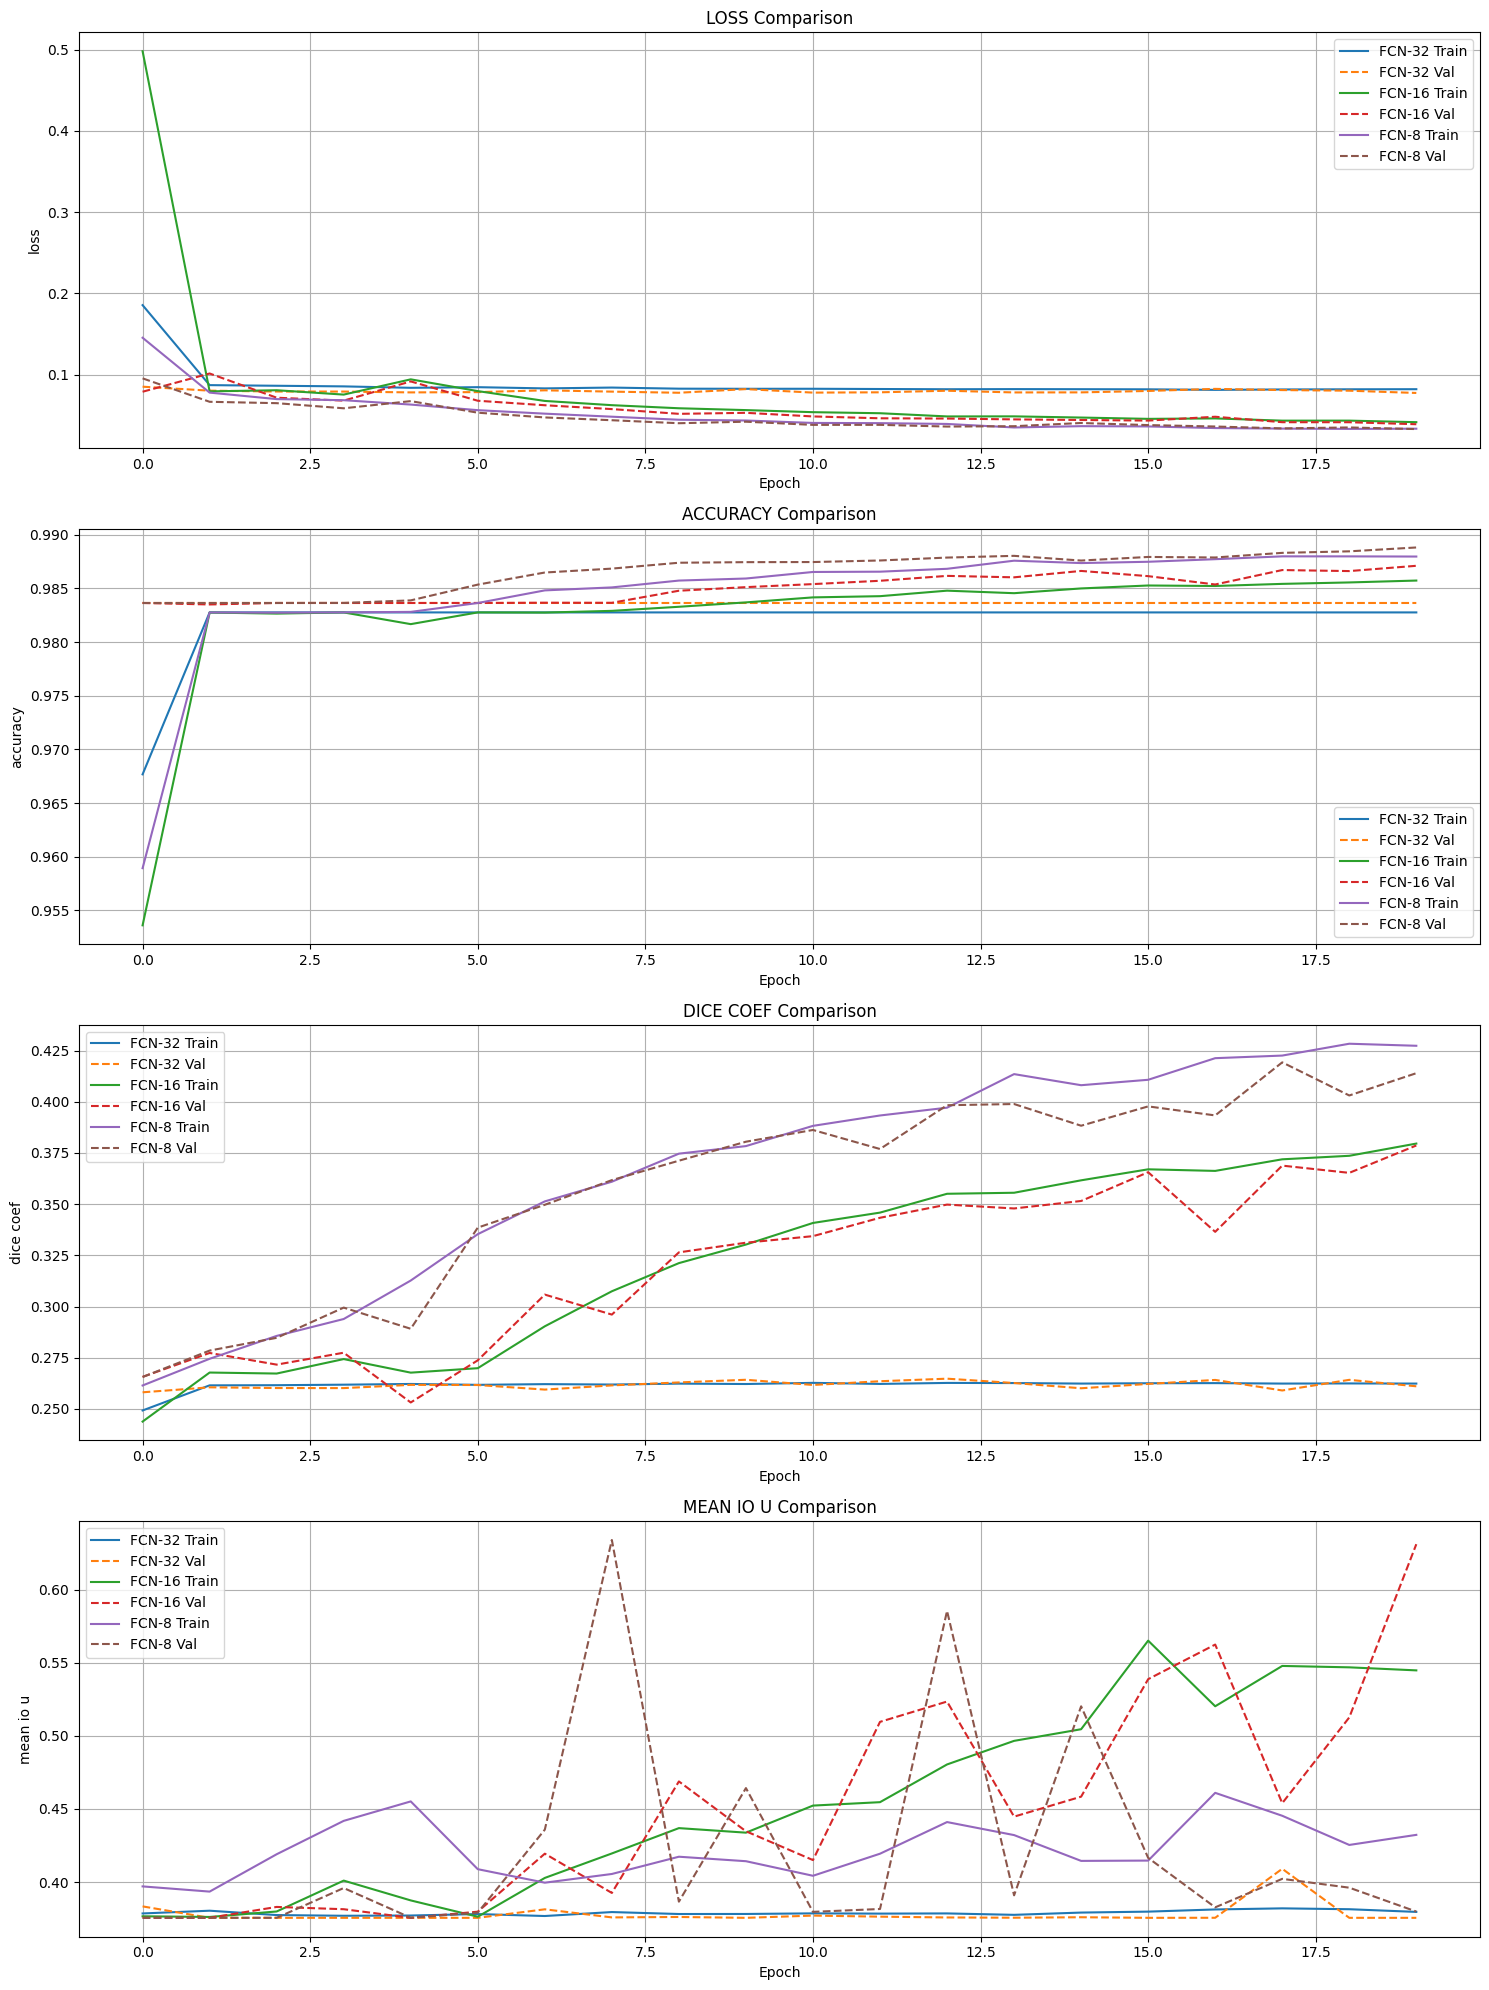

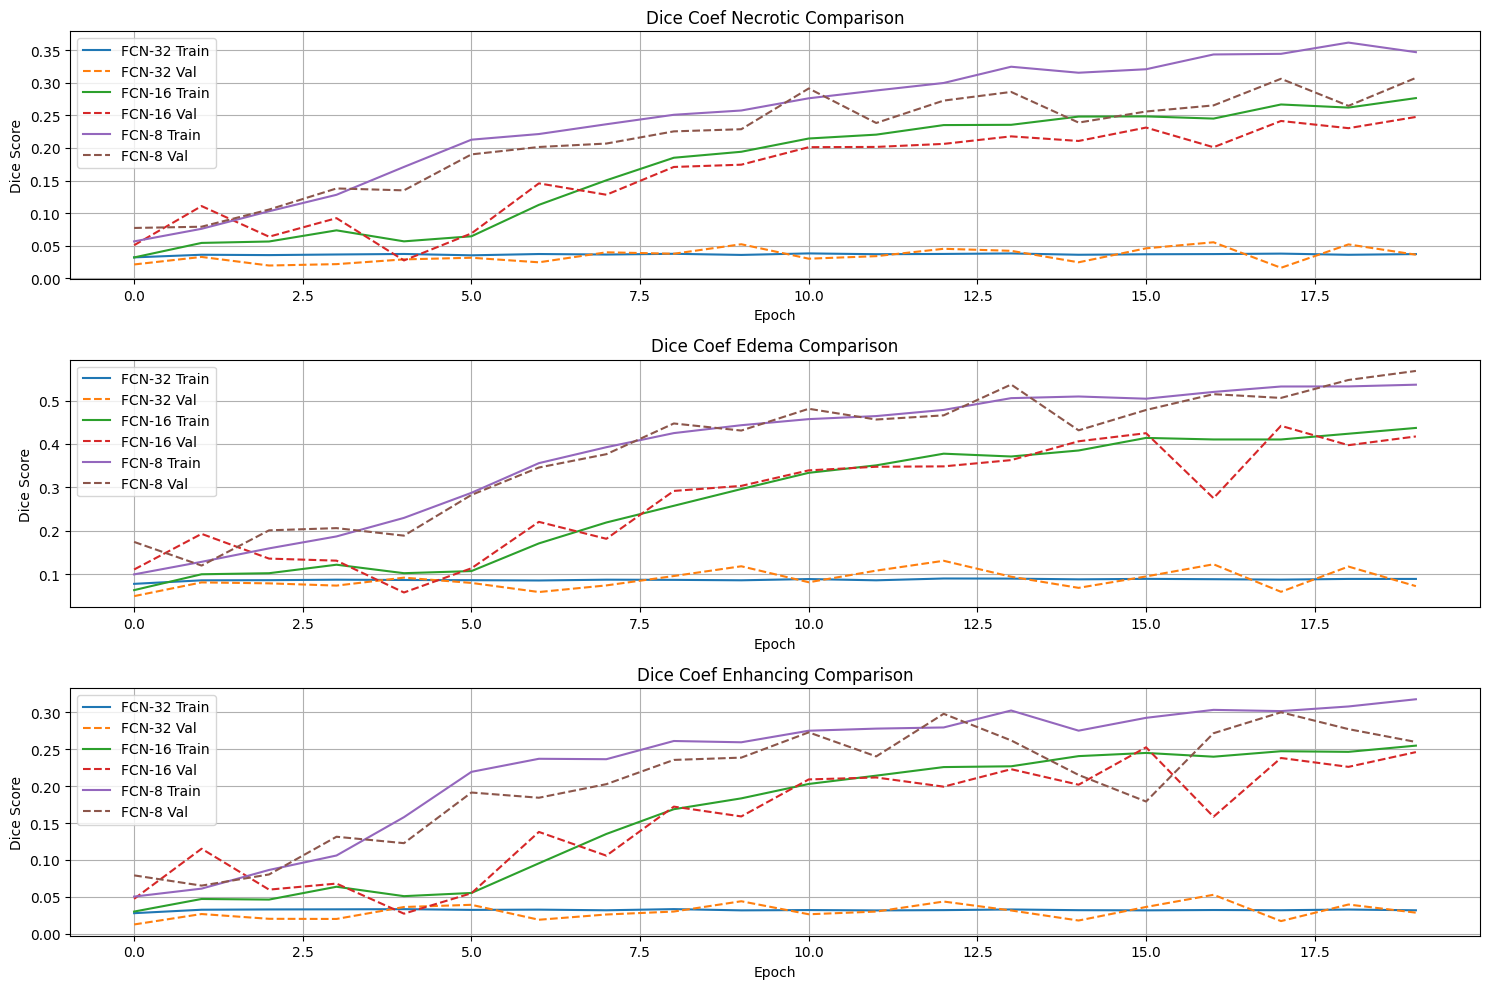

In [ ]:
def load_history(model_name):
    MODEL_SAVE_DIR = "/content/saved_models"

    history_files = sorted(
        [f for f in os.listdir(MODEL_SAVE_DIR)
         if f.startswith(f"{model_name}_history_BraTS20")],
        reverse=True
    )

    if not history_files:
        raise FileNotFoundError(f"No history found for {model_name}")

    latest_file = os.path.join(MODEL_SAVE_DIR, history_files[0])

    with open(latest_file, 'rb') as f:
        history_dict = pickle.load(f)

    print(f"Loaded history from {latest_file}")
    return history_dict

fcn32_history = load_history("FCN32")
fcn16_history = load_history("FCN16")
fcn8_history = load_history("FCN8")

histories_dict = {
    "FCN-32": fcn32_history,
    "FCN-16": fcn16_history,
    "FCN-8": fcn8_history
}


def plot_training_comparison(histories_dict, metrics):
    plt.figure(figsize=(15, 5*len(metrics)))

    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics), 1, i+1)

        for model_name, history in histories_dict.items():

            if metric not in history:
                print(f"Warning: Metric {metric} not found for {model_name}")
                continue


            plt.plot(history[metric],
                    linestyle='-',
                    label=f'{model_name} Train')

            val_metric = f'val_{metric}'
            if val_metric in history:
                plt.plot(history[val_metric],
                        linestyle='--',
                        label=f'{model_name} Val')

        plt.title(f'{metric.upper().replace("_", " ")} Comparison')
        plt.ylabel(metric.replace("_", " "))
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_comparison(
    histories_dict=histories_dict,
    metrics=['loss', 'accuracy', 'dice_coef', 'mean_io_u']
)

plt.figure(figsize=(15, 10))
class_dice_metrics = ['dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

for i, metric in enumerate(class_dice_metrics):
    plt.subplot(3, 1, i+1)
    for model_name, history in histories_dict.items():
        if metric not in history:
            print(f"Warning: Metric {metric} not found for {model_name}")
            continue

        plt.plot(history[metric], label=f'{model_name} Train')
        if f'val_{metric}' in history:
            plt.plot(history[f'val_{metric}'], '--', label=f'{model_name} Val')

    plt.title(f'{metric.replace("_", " ").title()} Comparison')
    plt.ylabel('Dice Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model = keras.models.load_model('/content/saved_models/FCN8_BraTS20_20250414_183142.h5',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = FCN32(input_shape=(IMG_SIZE, IMG_SIZE, 2), n_classes=4)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

model.load_weights('/content/saved_models/FCN32_BraTS20_20250414_162019.weights.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


<Figure size 1800x5000 with 0 Axes>

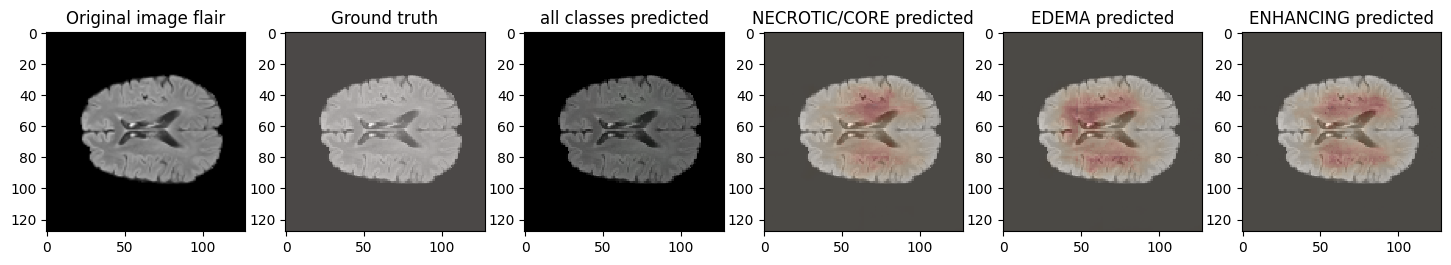

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

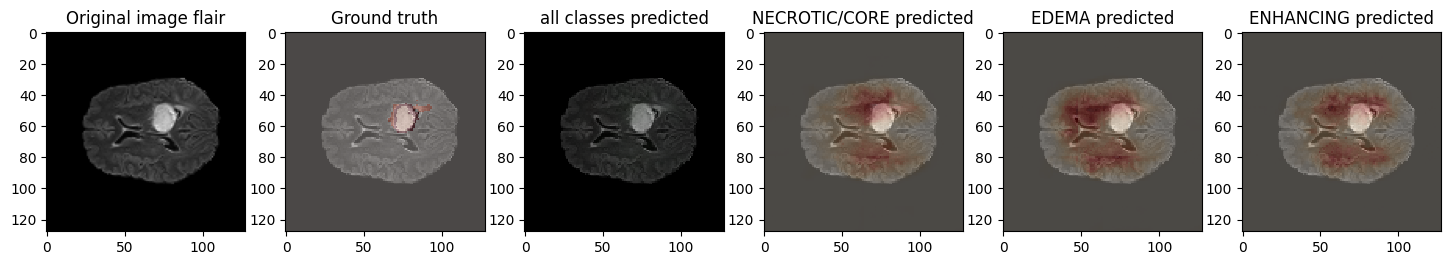

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

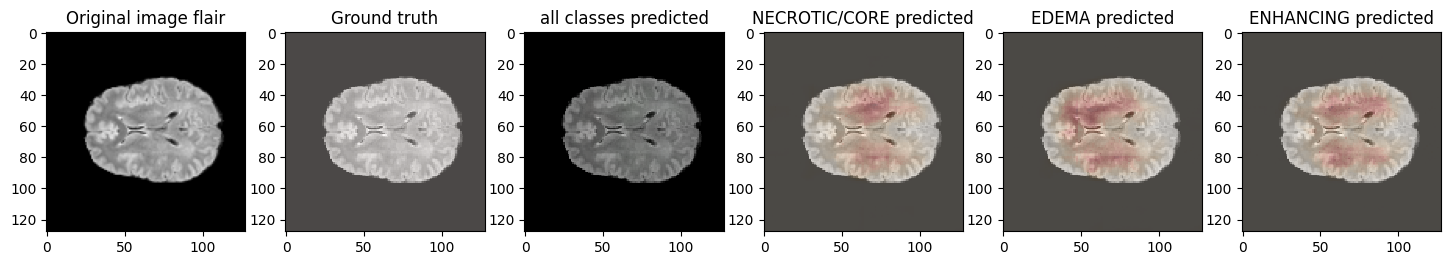

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

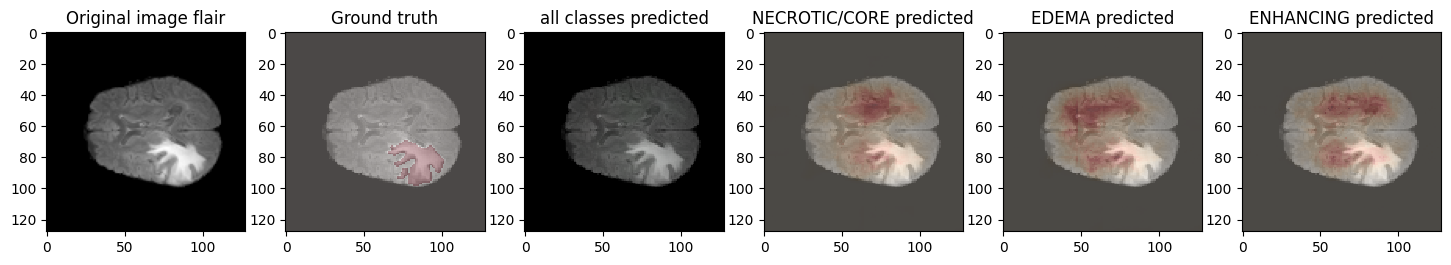

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

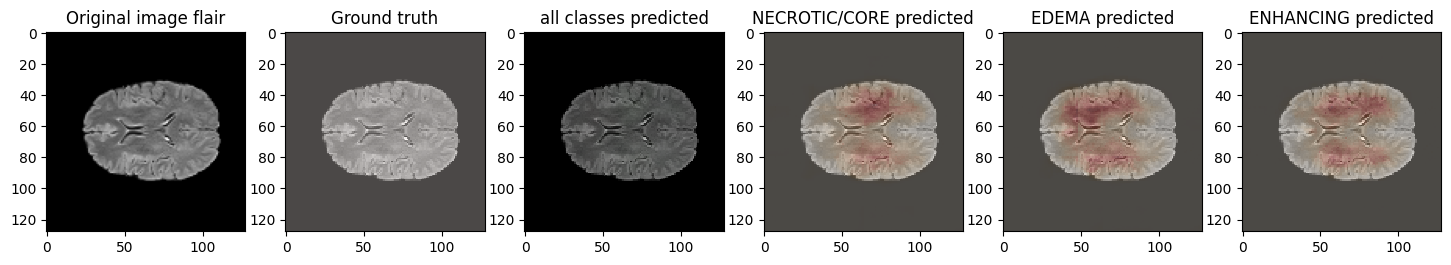

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

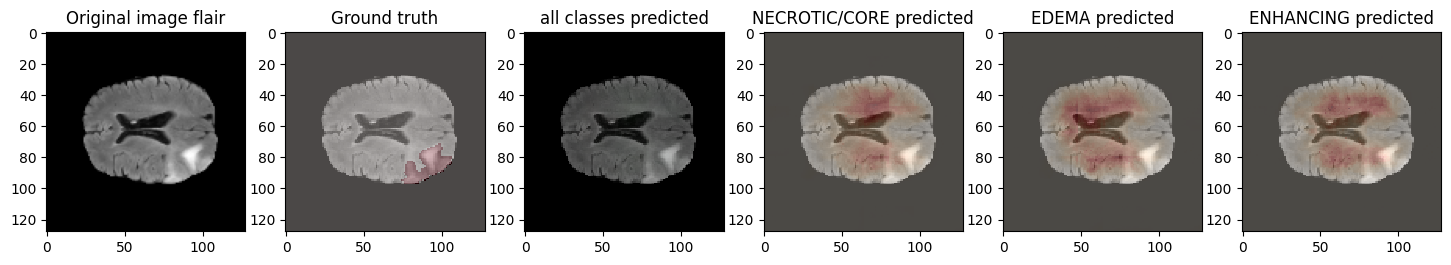

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

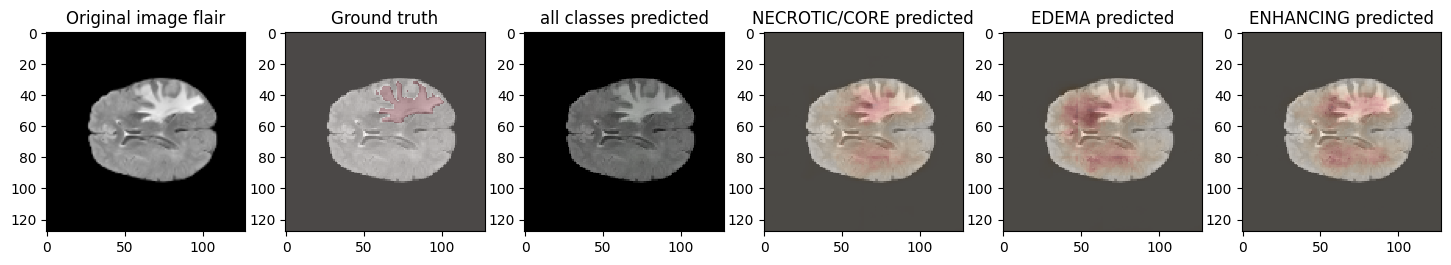

In [ ]:
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<Figure size 640x480 with 0 Axes>

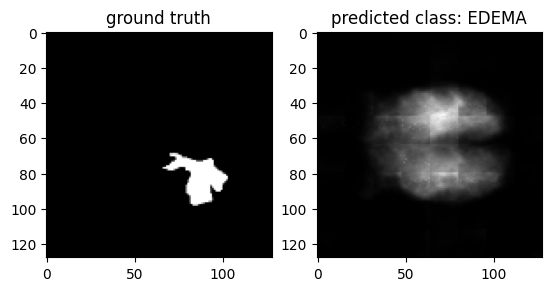

In [ ]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=67 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.9863 - dice_coef: 0.4148 - dice_coef_edema: 0.4860 - dice_coef_enhancing: 0.2361 - dice_coef_necrotic: 0.3399 - loss: 0.0375 - mean_io_u_34: 0.4411 - precision: 0.9905 - sensitivity: 0.9830 - specificity: 0.9967

Model evaluation on the test set:
Loss : 0.0349
Accuracy : 0.9882
MeanIOU : 0.4401
Dice coefficient : 0.4069
Precision : 0.9917
Sensitivity : 0.9851
Specificity : 0.9972
Dice coef Necrotic : 0.2917
Dice coef Edema : 0.4998
Dice coef Enhancing : 0.2411


In [ ]:
for model in [fcn32, fcn16, fcn8]:
    print(f"\n{model.name} Weights:")
    for layer in model.layers:
        if layer.weights:
            print(f"{layer.name}: {[w.shape for w in layer.weights]}")


fcn32 Weights:
block1_conv1: [TensorShape([3, 3, 2, 64]), TensorShape([64])]
block1_conv2: [TensorShape([3, 3, 64, 64]), TensorShape([64])]
block2_conv1: [TensorShape([3, 3, 64, 128]), TensorShape([128])]
block2_conv2: [TensorShape([3, 3, 128, 128]), TensorShape([128])]
block3_conv1: [TensorShape([3, 3, 128, 256]), TensorShape([256])]
block3_conv2: [TensorShape([3, 3, 256, 256]), TensorShape([256])]
block3_conv3: [TensorShape([3, 3, 256, 256]), TensorShape([256])]
block4_conv1: [TensorShape([3, 3, 256, 512]), TensorShape([512])]
block4_conv2: [TensorShape([3, 3, 512, 512]), TensorShape([512])]
block4_conv3: [TensorShape([3, 3, 512, 512]), TensorShape([512])]
block5_conv1: [TensorShape([3, 3, 512, 512]), TensorShape([512])]
block5_conv2: [TensorShape([3, 3, 512, 512]), TensorShape([512])]
block5_conv3: [TensorShape([3, 3, 512, 512]), TensorShape([512])]
fc6: [TensorShape([7, 7, 512, 4096]), TensorShape([4096])]
fc7: [TensorShape([1, 1, 4096, 4096]), TensorShape([4096])]
score_fr: [Tens

In [ ]:
K.clear_session()

model = keras.models.load_model('/content/drive/MyDrive/thesis/FCN8_BraTS20_20250414_212908.h5',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = keras.models.load_model('/content/drive/MyDrive/thesis/FCN8_BraTS20_20250414_212908.h5',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  })

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

#model.load_weights('/content/saved_models/FCN8_BraTS20_20250414_212908.weights.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


<Figure size 1800x5000 with 0 Axes>

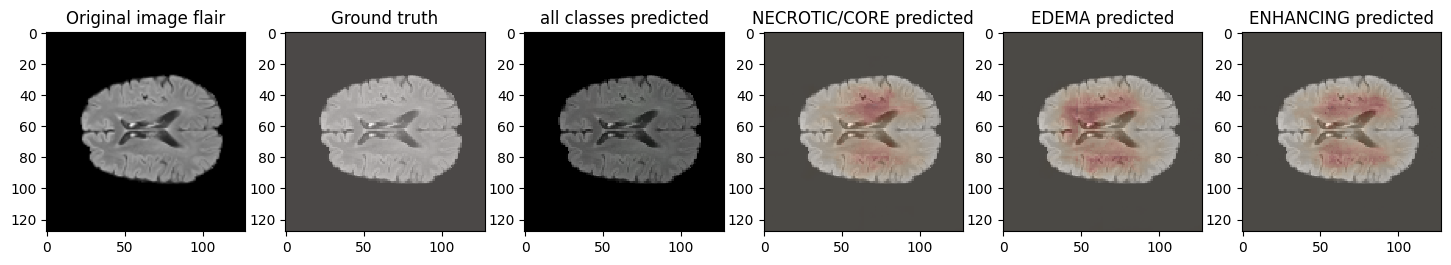

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

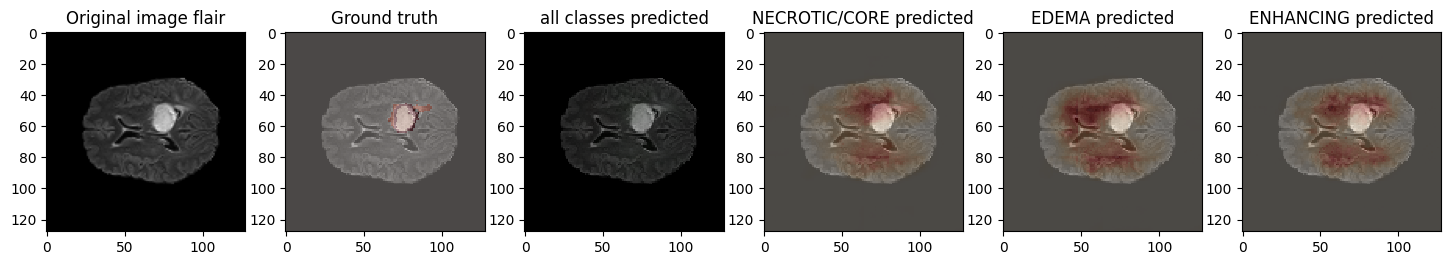

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

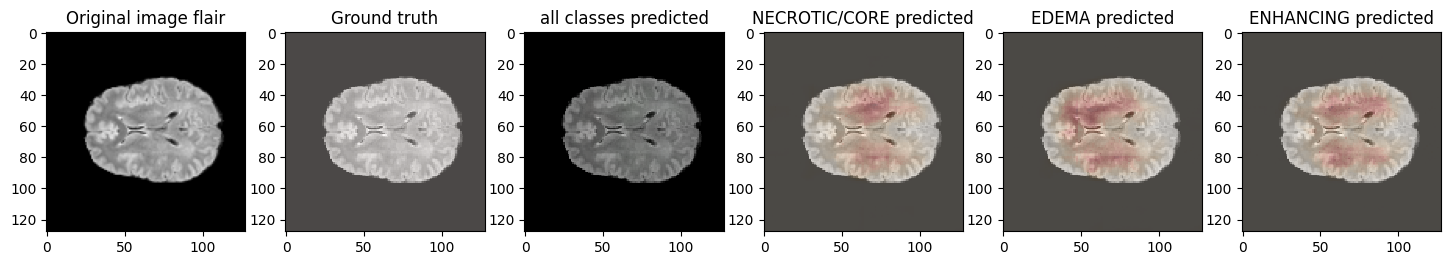

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

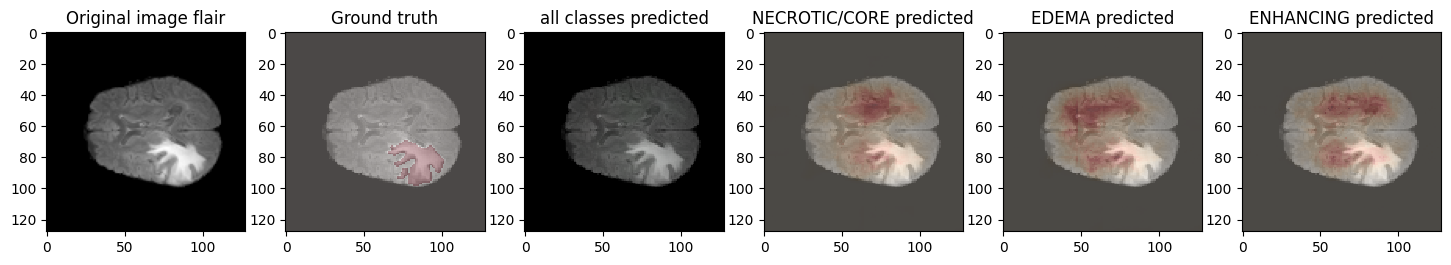

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

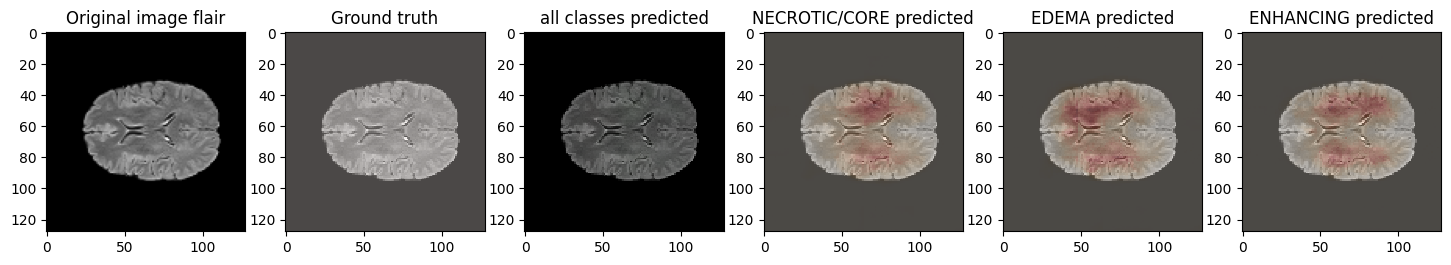

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

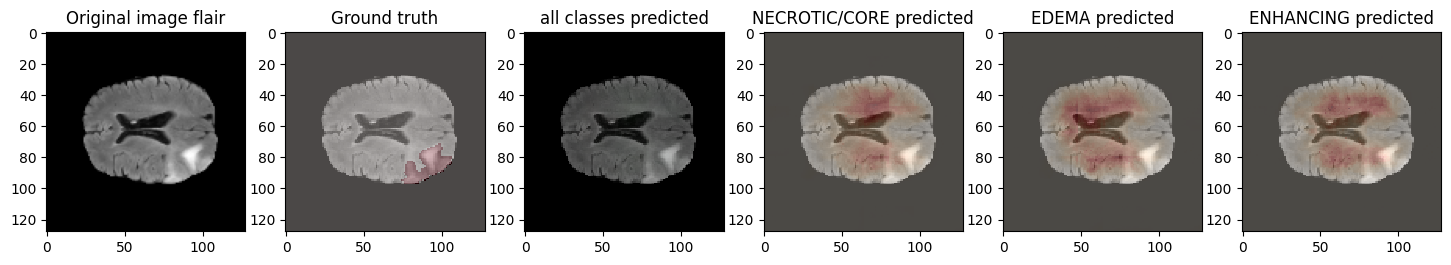

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

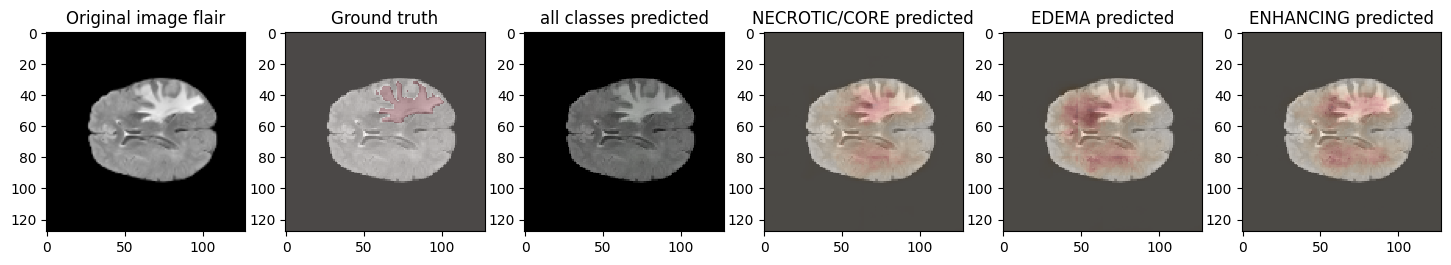

In [ ]:
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

In [ ]:
K.clear_session()

custom_objects = {
    "accuracy": tf.keras.metrics.MeanIoU(num_classes=4),
    "dice_coef": dice_coef,
    "precision": precision,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "dice_coef_necrotic": dice_coef_necrotic,
    "dice_coef_edema": dice_coef_edema,
    "dice_coef_enhancing": dice_coef_enhancing
}


model = tf.keras.models.load_model(
    '/content/drive/MyDrive/thesis/FCN8_BraTS20_20250414_212908.h5',
    custom_objects=custom_objects
)

print("Model Summary:")
model.summary()

first_conv_weights = model.layers[1].get_weights()[0]
print("\nFirst conv layer weights shape:", first_conv_weights.shape)
print("Mean weight value:", first_conv_weights.mean())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_iou'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

test_generator.on_epoch_end()
results = model.evaluate(test_generator, batch_size=100)
descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

Model Summary:


Model: "fcn32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc6 (Conv2D)                         │ (None, 4, 4, 4096)          │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc7 (Conv2D)                         │ (None, 4, 4, 4096)          │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,341,894 (512.47 MB)

 Trainable params: 134,341,892 (512.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


First conv layer weights shape: (3, 3, 2, 64)
Mean weight value: -0.0032276635
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9854 - dice_coef: 0.2610 - dice_coef_edema: 0.0705 - dice_coef_enhancing: 0.0332 - dice_coef_necrotic: 0.0333 - loss: 0.0702 - mean_iou: 0.3756 - precision: 0.9853 - sensitivity: 0.9854 - specificity: 0.9951

Model evaluation on the test set:
Loss : 0.0693
Accuracy : 0.9858
MeanIOU : 0.3755
Dice coefficient : 0.2601
Precision : 0.9858
Sensitivity : 0.9858
Specificity : 0.9953
Dice coef Necrotic : 0.0331
Dice coef Edema : 0.07
Dice coef Enhancing : 0.0306


In [ ]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = keras.models.load_model('/content/saved_models/FCN16_BraTS20_20250414_221345.h5',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])


In [ ]:
custom_objects = {
    "accuracy": tf.keras.metrics.MeanIoU(num_classes=4),
    "dice_coef": dice_coef,
    "precision": precision,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "dice_coef_necrotic": dice_coef_necrotic,
    "dice_coef_edema": dice_coef_edema,
    "dice_coef_enhancing": dice_coef_enhancing
}


model = keras.models.load_model('/content/drive/MyDrive/thesis/FCN16_BraTS20_20250414_221345.h5',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

print("Model Summary:")
model.summary()

first_conv_weights = model.layers[1].get_weights()[0]
print("\nFirst conv layer weights shape:", first_conv_weights.shape)
print("Mean weight value:", first_conv_weights.mean())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_iou'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

test_generator.on_epoch_end()
results = model.evaluate(test_generator, batch_size=100)
descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

Model Summary:


Model: "fcn32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc6 (Conv2D)                         │ (None, 4, 4, 4096)          │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc7 (Conv2D)                         │ (None, 4, 4, 4096)          │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,341,892 (512.47 MB)

 Trainable params: 134,341,892 (512.47 MB)

 Non-trainable params: 0 (0.00 B)


First conv layer weights shape: (3, 3, 2, 64)
Mean weight value: -0.0032276635
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.9839 - dice_coef: 0.2611 - dice_coef_edema: 0.0703 - dice_coef_enhancing: 0.0296 - dice_coef_necrotic: 0.0360 - loss: 0.0765 - mean_iou: 0.3755 - precision: 0.9838 - sensitivity: 0.9839 - specificity: 0.9946

Model evaluation on the test set:
Loss : 0.0693
Accuracy : 0.9858
MeanIOU : 0.3755
Dice coefficient : 0.2601
Precision : 0.9858
Sensitivity : 0.9858
Specificity : 0.9953
Dice coef Necrotic : 0.0331
Dice coef Edema : 0.07
Dice coef Enhancing : 0.0306


In [ ]:
import h5py
print("FCN16 weights:")
with h5py.File('/content/saved_models/FCN16_BraTS20_20250414_221345.h5', 'r') as f:
    print(list(f['model_weights'].keys())[:5])  # First 5 layers

print("\nFCN8 weights:")
with h5py.File('/content/saved_models/FCN8_BraTS20_20250414_212908.h5', 'r') as f:
    print(list(f['model_weights'].keys())[:5])

FCN16 weights:
['activation', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1']

FCN8 weights:
['activation', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1']


In [ ]:
import h5py

def check_model_architecture(model_path):
    with h5py.File(model_path, 'r') as f:
        # Check if the model has FCN16-specific layers
        has_fcn16_layers = any('fuse_pool4' in layer_name for layer_name in f.keys())
        print("Is this FCN16?", has_fcn16_layers)

check_model_architecture('/content/drive/MyDrive/thesis/FCN16_BraTS20_20250414_221345.h5')

Is this FCN16? False


In [ ]:
K.clear_session()

custom_objects = {
    "accuracy": tf.keras.metrics.MeanIoU(num_classes=4),
    "dice_coef": dice_coef,
    "precision": precision,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "dice_coef_necrotic": dice_coef_necrotic,
    "dice_coef_edema": dice_coef_edema,
    "dice_coef_enhancing": dice_coef_enhancing
}


model = tf.keras.models.load_model(
    '/content/drive/MyDrive/thesis/FCN8_BraTS20_20250414_212908.h5',
    custom_objects=custom_objects
)

print("Model Summary:")
model.summary()

first_conv_weights = model.layers[1].get_weights()[0]
print("\nFirst conv layer weights shape:", first_conv_weights.shape)
print("Mean weight value:", first_conv_weights.mean())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4, name='mean_iou'),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

test_generator.on_epoch_end()
results = model.evaluate(test_generator, batch_size=100)
descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

Model Summary:


Model: "fcn32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc6 (Conv2D)                         │ (None, 4, 4, 4096)          │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc7 (Conv2D)                         │ (None, 4, 4, 4096)          │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,341,894 (512.47 MB)

 Trainable params: 134,341,892 (512.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


First conv layer weights shape: (3, 3, 2, 64)
Mean weight value: -0.0032276635
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.9881 - dice_coef: 0.2595 - dice_coef_edema: 0.0717 - dice_coef_enhancing: 0.0330 - dice_coef_necrotic: 0.0302 - loss: 0.0596 - mean_iou: 0.3754 - precision: 0.9881 - sensitivity: 0.9881 - specificity: 0.9960

Model evaluation on the test set:
Loss : 0.0693
Accuracy : 0.9858
MeanIOU : 0.3755
Dice coefficient : 0.2601
Precision : 0.9858
Sensitivity : 0.9858
Specificity : 0.9953
Dice coef Necrotic : 0.0331
Dice coef Edema : 0.07
Dice coef Enhancing : 0.0306
